## Quantitative Risk Management Assignement
Giuliano Cunti <br>
Lukas Schreiner

In [1]:
#Import Libraries
import numpy as np
import pandas as pd

from copulas.bivariate.base import Bivariate
import scipy.stats as st

import matplotlib.pyplot as plt

#Set random number seed in order to generate coherent results
np.random.seed(1)

In [2]:
#Import Data MXEUC Index
data1 = pd.read_excel('qrm18HSG_assignmentdata.xlsx', usecols = "A,B" ,names = [ 'Date', 'MXEUC Index']).set_index('Date')
data1 = data1.iloc[1:]
#Import Data SPX Index
data2 = pd.read_excel('qrm18HSG_assignmentdata.xlsx', usecols = "C,D" ,names = [ 'Date', 'SPX Index']).set_index('Date')
data2 = data2.iloc[1:]

#Merge Data
data = pd.concat([data1, data2], axis = 1, join_axes = [data1.index])

#Convert to numerical values interpolate missing values
data['SPX Index'] = pd.to_numeric(data['SPX Index'])
data['MXEUC Index'] = pd.to_numeric(data['MXEUC Index'])
data['SPX Index'] = data['SPX Index'].interpolate()

#Calculate Returns of the Indices
data['MXEUC Returns'] = data['MXEUC Index']/data['MXEUC Index'].shift(1) - 1
data['SPX Returns'] = data['SPX Index']/data['SPX Index'].shift(1) - 1

#Only take the newest 500 Oberservations
data = data.iloc[1:501]

data.head()

,MXEUC Index,SPX Index,MXEUC Returns,SPX Returns
Date,,,,
2005-01-03,89.6602,1202.0891,0.005159,-0.008109
2005-01-04,90.0505,1188.1801,0.004353,-0.011571
2005-01-05,89.4664,1183.9815,-0.006486,-0.003534
2005-01-06,89.9265,1188.3980,0.005143,0.003730
2005-01-07,90.6058,1186.7126,0.007554,-0.001418


### Question i)

<b>Model 1</b> <br>
<br>
R is distributed according to the empirical distribution.

In [3]:
#Calculate the emprical CDF
empricial_cdf = np.array([data.sort_values('MXEUC Returns')['MXEUC Returns'].values, 
                 data.sort_values('SPX Returns')['SPX Returns'].values])

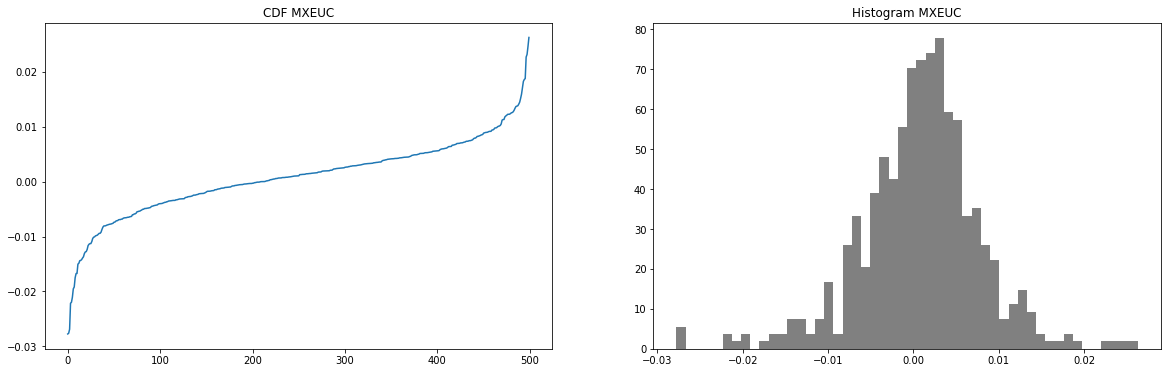

In [4]:
#Plot CDF and histogramm of the MXEUC
figure_MXEUC = plt.figure(figsize = (20,6))

chart_1  = figure_MXEUC.add_subplot(121)
chart_1.plot(empricial_cdf[0])
chart_1.set_title('CDF MXEUC')

chart_2  = figure_MXEUC.add_subplot(122)
chart_2.hist(empricial_cdf[0], 50 ,density = True, facecolor = 'grey')
chart_2.set_title('Histogram MXEUC')

plt.show()

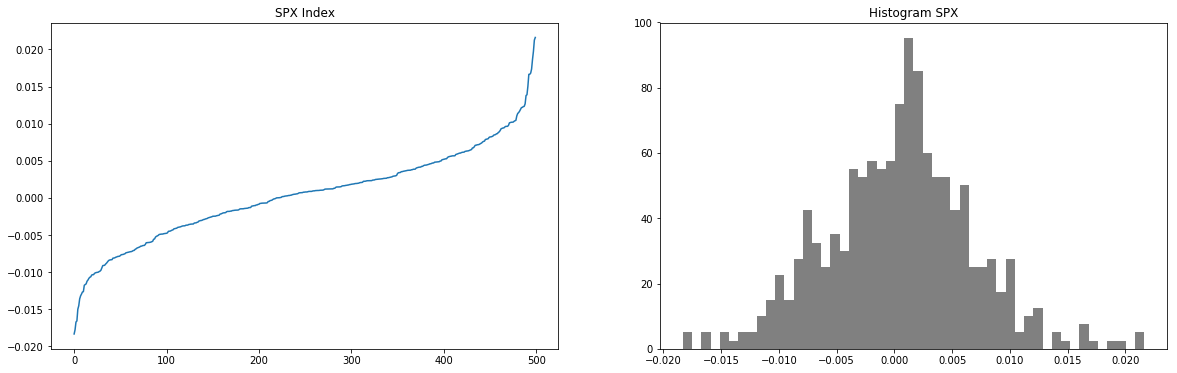

In [5]:
#Plot CDF and histogramm of the SPX
figure_SPX = plt.figure(figsize = (20,6))

chart_1  = figure_SPX.add_subplot(121)
chart_1.plot(empricial_cdf[1])
chart_1.set_title('SPX Index')

chart_2  = figure_SPX.add_subplot(122)
chart_2.hist(empricial_cdf[1], 50 ,density = True, facecolor = 'grey')
chart_2.set_title('Histogram SPX')

plt.show()

<b>Model 2</b><br>
<br>
R is bivariate Gaussian distributed with mean vector μ and covariance matrix Σ

In [6]:
#Calculate Sample Means and Variances
means = [np.mean(data['MXEUC Returns']), np.mean(data['SPX Returns'])]
print(means)
variances = [np.var(data['MXEUC Returns']), np.var(data['SPX Returns'])]
print(variances)

[0.0007688865556201618, 0.00037513875090646164]
[5.061087267757628e-05, 3.915794768807607e-05]


In [7]:
#Calculate Covariance Matrix
cov_mat = np.cov(data['MXEUC Returns'], data['SPX Returns'], ddof = 0)
print(cov_mat)

[[5.06108727e-05 1.92605961e-05]
 [1.92605961e-05 3.91579477e-05]]


<b>Model 3</b> <br>
<br>
Ri is Gaussian distributed with mean μ and variance σ, for i = 1, 2. These parameters
are the same as for model M2.

Moreover, the normalized vector of returns possesses a Gumbel-copula with parameter θ ≥ 1

In [8]:
#Normalize the data
data['MXEUC Returns Normalized'] = (data['MXEUC Returns'] - means[0])/(np.sqrt(variances[0]))
data['SPX Returns Normalized'] = (data['SPX Returns'] - means[1])/(np.sqrt(variances[1]))

#Apply the normalized data on a CDF to get probablities
data['MXEUC RN CDF'] = st.norm.cdf(data['MXEUC Returns Normalized'].values)
data['SPX RN CDF'] = st.norm.cdf(data['SPX Returns Normalized'].values)

In [9]:
#Create an array that contains only the return data
gumbel_data = np.array([data['MXEUC RN CDF'], data['SPX RN CDF']]).T

In [10]:
#Fit a bivariate gumbel copula
#The copulas library from Data to AI Lab at MIT is used
#https://pypi.org/project/copulas/

gumbel = Bivariate(copula_type = 'Gumbel')
gumbel.fit(gumbel_data)
gumbel.compute_theta()

1.3831731143911365

<b>Model 4</b><br>
<br>
Ri = μi + σi εi, where εi is standard t-distributed with νi degrees of freedom. The parameters μi and σi, i = 1, 2, are the same as for model M2. The vector (ε1,ε2)′ possesses a Gaussian copula with correlation parameter ρ.

In [11]:
#[...]

### Question ii)
<br>
Using model M1 for R, simulate the portfolio distribution (10,000 simulations of the portfolio return) and estimate 1-day portfolio’s value-at-risk and expected shortfall at 90%, 95% and 99% confidence levels.

In [12]:
#Define Expetected Shortfall
def exp_shortfall(alpha, data):
    
    mu = np.mean(data)
    sigma = np.std(data)
    
    return (1 - alpha)** -1 * st.norm.pdf(st.norm.ppf(alpha))*sigma - mu

#Define Value at Risk
def var(alpha, data):
    return - (np.mean(data) - st.norm.ppf(alpha) * np.std(data))

In [13]:
rand_int = np.random.randint(0,500,10000)
random_return_series = np.array([empricial_cdf[0][rand_int], empricial_cdf[1][rand_int]])

In [14]:
output_EF = dict.fromkeys(['MXEUC','SPX'])

#Calculate the Expected Short Fall for MXEUC
output_EF['MXEUC'] = [exp_shortfall(0.1, random_return_series[0]), 
                   exp_shortfall(0.05, random_return_series[0]),
                   exp_shortfall(0.01, random_return_series[0])]

#Calculate the Expected Short Fall for SPX
output_EF['SPX'] =  [exp_shortfall(0.1, random_return_series[1]), 
                   exp_shortfall(0.05, random_return_series[1]),
                   exp_shortfall(0.01, random_return_series[1])]

output_table_EF = pd.DataFrame(output_EF, index = ['90%', '95%', '99%'])
output_table_EF.index.name = 'Exp. SF'
output_table_EF       

,MXEUC,SPX
Exp. SF,,
90%,0.000563,0.000808
95%,-0.000045,0.000271
99%,-0.000618,-0.000236


In [15]:
output_VAR = dict.fromkeys(['MXEUC','SPX'])

#Calculate the Value at Risk Fall for MXEUC
output_VAR['MXEUC'] = [var(0.1, random_return_series[0]), 
                   var(0.05, random_return_series[0]),
                   var(0.01, random_return_series[0])]

#Calculate the Value at Risk Fall for SPX
output_VAR['SPX'] =  [var(0.1, random_return_series[1]), 
                   var(0.05, random_return_series[1]),
                   var(0.01, random_return_series[1])]

output_table_VAR = pd.DataFrame(output_VAR, index = ['90%', '95%', '99%'])
output_table_VAR.index.name = 'VAR'
output_table_VAR       

,MXEUC,SPX
VAR,,
90%,-0.009807,-0.008362
95%,-0.012359,-0.010619
99%,-0.017145,-0.014851


### Question iii)
<br>
Repeat the same exercise as in point (ii), but using models M2 and M4, respectively.